# Описание
Этот ноутбук содержит решение десятного домашнего задания "Оценивание плотностей. Непараметрическая регрессия"

## Результаты
1. Написана полностью
2. Написана полностью
3. Написана полностью
4. Написана полностью
5. Написана полностью

## Материалы:

* [Условие задач](mspsdz101.pdf)
* [лекция](msps201810.pdf)

# Setup

## Library import
We import all the required Python libraries

In [406]:
import pandas as pd

import numpy as np

import scipy.stats as sps

import matplotlib.pyplot as plt

from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.interpolate import UnivariateSpline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Решения

## Задача 1

Исходная постановка задачи выглядит следующим образом:

$$
\widehat{a}(x),\ \widehat{b}(x) = \arg\min_{a(x),\ b(x)}\sum\limits_{i=1}^{n}q_{h(x)}(X_i-x)\left(Y_i-a(x)-b(x)(X_i-x)\right)^2
$$

**План решения:** сначала сведём минимизацию к матричному виду, а далее решим задачу оптимизации, как в случае обычной линейной регресии

Для начала сделаем следующие замены:

$K_{h(x)} = diag(q_{h(x)}(X_1-x), q_{h(x)}(X_2-x), \dots, q_{h(x)}(X_n-x))$

$K_{h(x)}^{\frac{1}{2}} = diag(q_{h(x)}^{\frac{1}{2}}(X_1-x), q_{h(x)}^{\frac{1}{2}}(X_2-x), \dots, q_{h(x)}^{\frac{1}{2}}(X_n-x))$

$Y$ - вектор $(Y_1, Y_2, \dots, Y_n)$

$X_x$ - вектор $(X_1-x, X_2-x, \dots, X_n-x)$

$X$ - матрица $\left[1, X_x\right]$ размера $n\times2$, где в первом столбце одни единицы, а во втором вектор $X_x$

$w$ - вектор $(a(x), b(x))$


Очевидны следующие свойства:

$K_{h(x)}^{\frac{1}{2}} \times K_{h(x)}^{\frac{1}{2}} = K_{h(x)}$

Тогда:

$
\arg\min\limits_{a(x),\ b(x)}\sum\limits_{i=1}^{n}q_{h(x)}(X_i-x)\left(Y_i-a(x)-b(x)(X_i-x)\right)^2
= \arg\min\limits_{a(x),\ b(x)}||K_{h(x)}^{\frac{1}{2}}\times(Y-Xw)||^2_2
= \arg\min\limits_{a(x),\ b(x)}||K_{h(x)}^{\frac{1}{2}}Y-K_{h(x)}^{\frac{1}{2}}Xw||^2_2
$

Выразим аналитически решение для $w$:

$w = ((K_{h(x)}^{\frac{1}{2}}X)^T(K_{h(x)}^{\frac{1}{2}}X))^{-1}(K_{h(x)}^{\frac{1}{2}}X)^T(K_{h(x)}^{\frac{1}{2}}Y)
= (X^T K_{h(x)}X))^{-1}X^T K_{h(x)}Y)$

## Задача 2

* Загрузим выборку

In [29]:
X = pd.read_csv('./data/glass.dat', sep='\\s*', engine='python')['RI'].values

/Users/alex-kozinov/opt/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2420: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/alex-kozinov/opt/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2423: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [31]:
X.shape

(214,)

* Построим гистограму из 14 бинов

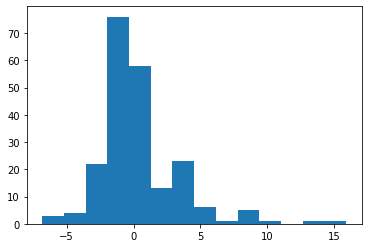

In [37]:
plt.hist(X, bins=14)
plt.show()

* Опишим **план** решения

1. Найдём *bandwidth* по формуле $\frac{1}{n}\sum\limits_{i=1}^{n}d_{iK}$, где $d_{iK}$ – расстояние от $X_i$ до $K$-того ближайшего. K положем равным 7
2. Далее при помощи бутстрепа оценим доверительный интервал 
3. Отобразим результат на графике

* Найдём *bandwidth*

In [119]:
def count_d(item, X, k=7):
    return np.sort(np.abs(item - X))[k]

bandwidth = np.mean([count_d(item, X) for item in X])
print(f'bandwidth is {bandwidth}')

bandwidth is 0.38710280373831785


* Оценим грацицы доверительного интервала

In [121]:
class CI_Estimator:
    def __init__(self, niter=2000):
        self.niter = niter
        self.kde_list = []

    def fit(self, sample, bandwidth):
        n = len(sample)
        for _ in range(self.niter):
            bootstrap_sample = np.random.choice(sample, n, replace=True)
            kde = KDEUnivariate(bootstrap_sample)
            kde.fit(bw=bandwidth)
            self.kde_list.append(kde)            
    
    def get_bounds(self, grid, alpha):
        density = np.array([kde.evaluate(grid) for kde in self.kde_list])
        density = np.sort(density, axis=0)
        left_pos = int(self.niter * alpha / 2)
        right_pos = self.niter - left_pos

        return density[left_pos], density[right_pos]

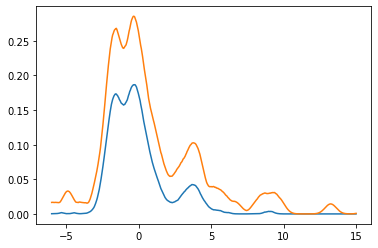

In [122]:
ci_e = CI_Estimator()
ci_e.fit(X, bandwidth)

grid = np.linspace(-6, 15, 500)
l, r = ci_e.get_bounds(grid, 0.05)

plt.plot(grid, l)
plt.plot(grid, r)
plt.show()

* Соберём всё вместе

In [123]:
kde = KDEUnivariate(X)
kde.fit(bw=bandwidth)

ci_e = CI_Estimator()
ci_e.fit(X, bandwidth)

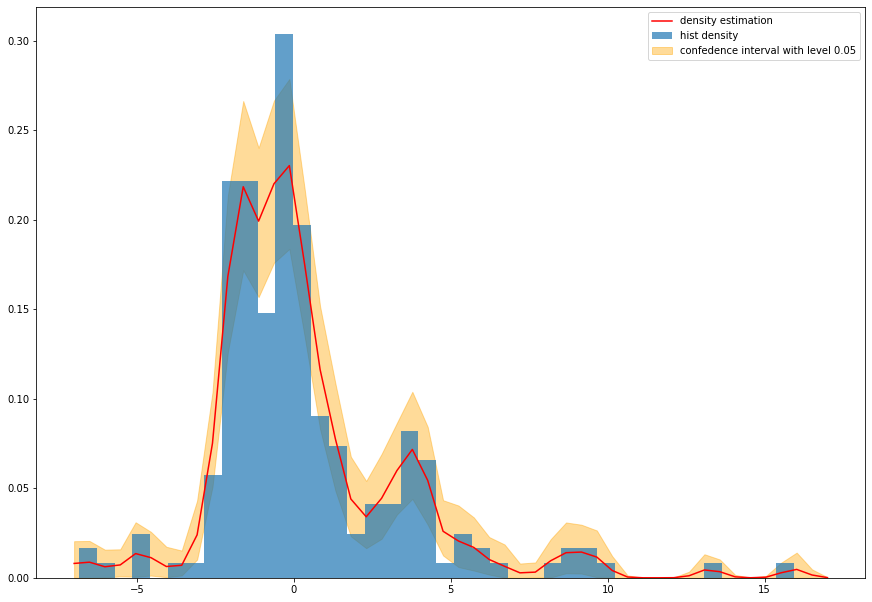

In [146]:
grid = np.linspace(-7, 17)
alpha = 0.05
density = kde.evaluate(grid)
l_ci, r_ci = ci_e.get_bounds(grid, alpha)

plt.figure(figsize=(29.7/2, 21.0/2))

plt.hist(X, bins=40, density=True, alpha=0.7, label='hist density')
plt.plot(grid, density, color='r', label='density estimation')
plt.fill_between(grid, l_ci, r_ci, alpha=0.4, color='orange', label=f'confedence interval with level {alpha}')

plt.legend()
plt.show()

* **Вывод** Можно заметить, что нам удалось оценить плотность довольно гладко. А так же что гистограмма попадает в доверительный интервал

## Задача 3

* Загрузим данные:

In [251]:
data = pd.read_csv('./data/hw10t3.csv')
X = data.x
y = data.y
X, y = np.array(sorted(list(zip(list(X), list(y))), key=lambda x: x[0])).T
data.head()

,Unnamed: 0,y,x
0,0,0.064771,0.180249
1,1,-0.683449,-0.811201
2,2,0.501485,-0.616333
3,3,0.263588,-0.749556
4,4,-0.323165,-0.414561


* Взглянем на данные

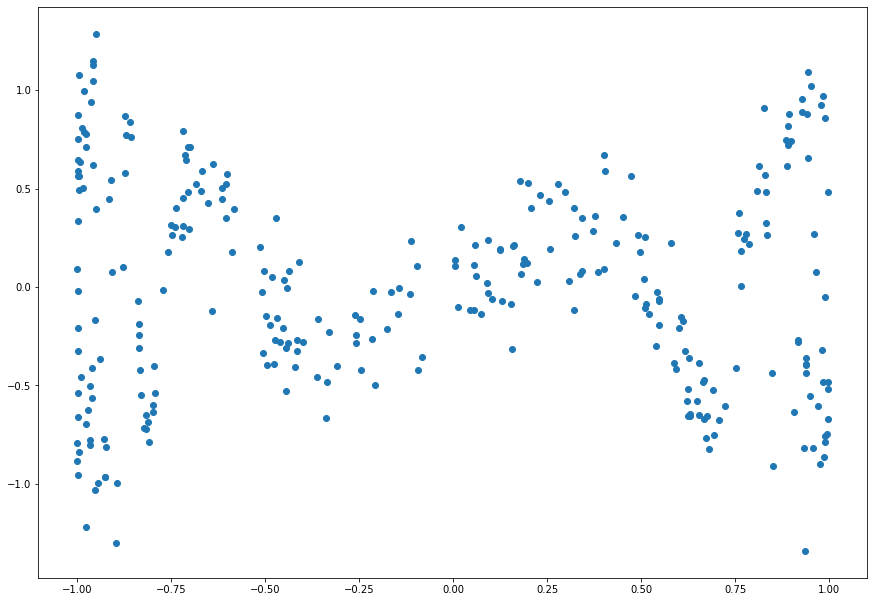

In [252]:
plt.figure(figsize=(29.7/2, 21.0/2))
plt.scatter(X, y)
plt.show()

* Обучим модель Надарайа-Ватсона. С поиском оптимального *bandwidth* при помощи кросс-валидации

In [297]:
"""
FROM:
https://github.com/jmetzen/kernel_regression
"""


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.
    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.
    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.
    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.
    See also
    --------
    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values
        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [320]:
gs = RandomizedSearchCV(
    KernelRegression(),
    param_distributions={'gamma': sps.uniform(loc=0, scale=500)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    random_state=13,
    n_iter=500
).fit(X.reshape(-1, 1), y)

kr = gs.best_estimator_
kr

KernelRegression(gamma=174.89110680051573, kernel='rbf')

* Обучим модель метода сглаживающего сплайна. Количество узлов (взвешивающий фактор $h$ подбирается эмперически)

In [321]:
ss = UnivariateSpline(X, y, k=2, s=50)

* Соберём всё вместе и отобразим на графике

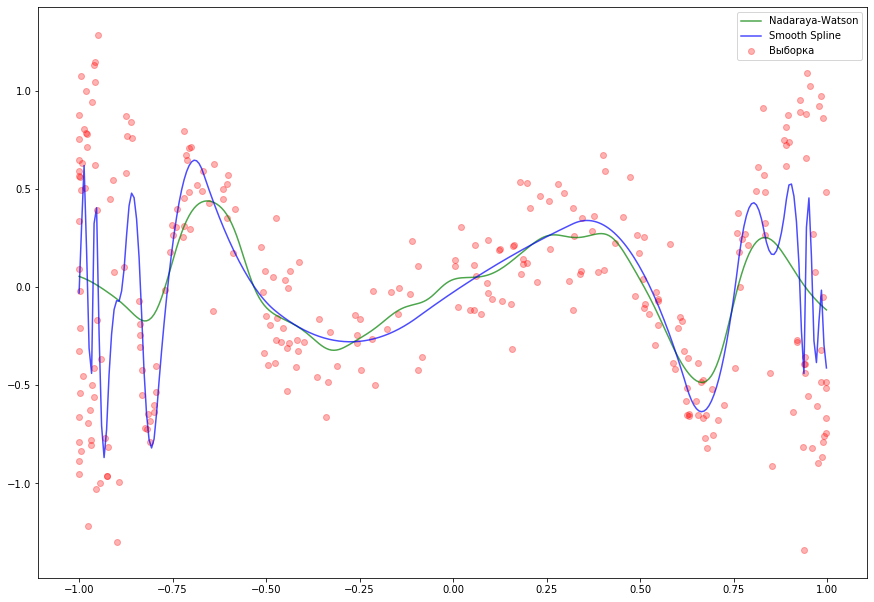

In [322]:
grid = np.linspace(np.min(X), np.max(X), 300)
# y_nw = kr.fit(grid)[0]
y_nw = kr.predict(grid.reshape(-1, 1))
y_ss = ss(grid)

plt.figure(figsize=(29.7/2, 21.0/2))

plt.plot(grid, y_nw, alpha=0.7, color='g', label='Nadaraya-Watson')
plt.plot(grid, y_ss, alpha=0.7, color='b', label='Smooth Spline')
plt.scatter(X, y, alpha=0.3, color='r', label='Выборка')

plt.legend()
plt.show()

* **Ответы на воросы**

> Зачем, на ваш взгляд, добавлять в выражение суммы квадратов интеграл от квадрата второй производной функции $m$?

Мне кажется, это сделано для того, чтобы сгладить интерполирующий график. Это похоже на регуляризацию, которая помогает бороться с переобучением

> Какой выбор $h$, на ваш взгляд, является оптимальным

Я выбирал коэффициент сглаживания опираясь на то, на сколько график получается острым. Хотелось учесть два аспекта: чтобы график угадывал тренд данных и чтобы он не изгибался к отдалёным элементам выборки, так как это могут быть выбросы. Например, как здесь:

<img src="./img_src/example1.png" alt="drawing" width="100"/>

> Где отличаются графики оценки Надаря-Ватсона и сглаживающего сплайна?

Больше всего различия заметны в центре:

<img src="./img_src/example2.png" alt="drawing" width="300"/>

Причём сглаживающий сплайн даже при сильно меньших коэффициентах сглаживания не вёл себя так

> и как вы это объясните?

Мне кажется, что интегральный остаток в формуле сглаживающего сплайна весит много, чтобы позволять так метаться вверх-вниз

## Задача 4

* Загрузим данные

In [339]:
data = pd.read_csv('./data/hw10t4.csv')

X = data[data.columns[1:-1]].values
y = data.Marmaduke.values
data.head()

,Unnamed: 0,Andrew,Bernard,Carle,Davide,Eugene,Fred,George,Marmaduke
0,0,-36.944209,7.115482,3.076607,1.832458,2.059673,0.112941,-0.706182,5.409550
1,1,-76.268155,9.871361,1.854843,1.628231,2.818672,0.061049,-0.595321,4.869631
2,2,-45.020962,7.772921,1.019105,1.595419,-0.906164,0.236599,-1.759698,3.493061
3,3,-31.935210,6.670168,2.117598,-1.274111,1.835605,0.270813,1.996759,4.904334
4,4,-40.738145,7.432577,0.048449,-0.865901,2.321549,0.086520,1.720531,3.247345


* Изучим их

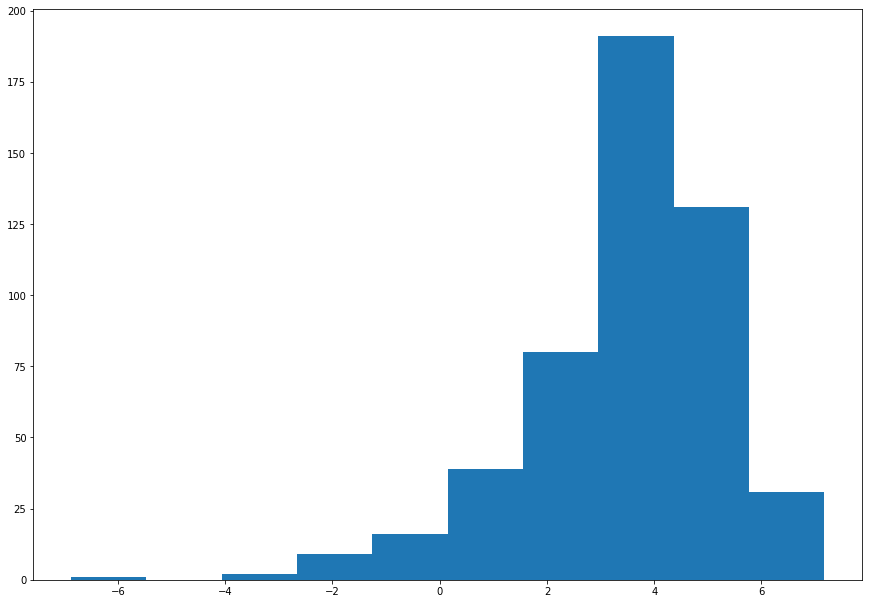

In [340]:
plt.figure(figsize=(29.7/2, 21.0/2))
plt.hist(y)
plt.show()

* Найдём оптимальную оценку Надарайа-Ватсона

In [359]:
gs = RandomizedSearchCV(
    KernelRegression(),
    param_distributions={'gamma': sps.uniform(loc=0.1, scale=2)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    random_state=13,
    n_iter=500
).fit(X, y)

kr = gs.best_estimator_
print("Best score is ", gs.best_score_)
kr

Best score is  -1.920560622706318


KernelRegression(gamma=0.41015757793906793, kernel='rbf')

* Найдём оптимальную линейную регрессию

В этом задинии линейная регрессия нужно лишь просто для демонстрации бейзлайна. Но после прошлого дз в качестве бейзлайна решил взять гребневую регрессию

In [365]:
gs = RandomizedSearchCV(
    Ridge(),
    param_distributions={'alpha': sps.uniform(loc=0.01, scale=10)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    n_iter=100
).fit(X, y)

lr = gs.best_estimator_
print("Best score is ", gs.best_score_)
lr

Best score is  -1.7437368929157788


Ridge(alpha=8.452930539549639, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

* Найдём оптимальную модель алгоритма настройки с возвращением

В стандартных библиотеках такого метода не нашёл. Поэтому реализую по алгоритму из лекции

<img src="./img_src/example3.png" alt="drawing" width="450"/>

In [383]:
class ConfigureReturn(BaseEstimator):
    def __init__(self, gamma=None, niter=1):
        self.gamma = gamma
        self.niter = niter
    
    def initialize_phi(self, X, y):
        lr = LinearRegression()
        lr.fit(X, y)
        self.phi = [lambda x: coef * x.flatten() for coef in lr.coef_]
    
    def step(self, X, y):
        n, k = X.shape
        for j in range(k):
            z = y
            for j1 in range(k):
                if j1 == j:
                    continue
                    
                z = z - self.phi[j1](X.T[j1].reshape(-1, 1))

            kr = KernelRegression(gamma=self.gamma)
            kr.fit(X.T[j].reshape(-1, 1), z)
            self.phi[j] = kr.predict

    def fit(self, X, y):
        assert len(X.shape) == 2

        self.initialize_phi(X, y)
        for _ in range(self.niter):
            self.step(X, y)
            
    def predict(self, X):
        n, k = X.shape
        z = np.zeros(n)
        for j in range(k):
            z += self.phi[j](X.T[j].reshape(-1, 1))
        return z

In [387]:
gs = RandomizedSearchCV(
    ConfigureReturn(niter=3),
    param_distributions={'gamma': sps.uniform(loc=0.1, scale=20)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    n_iter=40
).fit(X, y)

cr = gs.best_estimator_
print("Best score is ", gs.best_score_)
cr

Best score is  -0.43581927407770155


ConfigureReturn(gamma=5.105706097213753, niter=3)

* **Вывод** Можно заметить, что настройка с возвращением отработала лучше всего. В то время как оценка Надарайа-Ватсона хуже регрессии

## Задача 5

* Загрузим данные

In [397]:
data = pd.read_csv('./data/hw10t5_train.csv')
data = data[data.columns[4:]] # get rid of categorical columns

test_mask = data.y.isnull()
train_mask = ~test_mask

train = shuffle(data[train_mask])
test = data[test_mask]

X_train = train[train.columns[:-1]]
y_train = train[train.columns[-1]]

X_test = test[test.columns[:-1]]

* Изучим поближе данные

In [401]:
data.head()

,3,4,5,6,7,8,9,10,11,12,13,y
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0,5.238254
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1,7.474420
2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2,7.011719
3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3,2.288058
4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4,3.391995


In [402]:
data.describe()

,3,4,5,6,7,8,9,10,11,12,13,y
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,800.000000
mean,-3.203652,1.881316,-0.507597,0.515716,-0.306413,0.630319,-0.004140,0.336777,-0.302004,-0.072116,4.994944,4.917089
std,0.869422,1.175782,0.712288,0.759610,0.664514,0.604172,0.462106,0.573549,0.570077,0.603796,3.161473,2.398512
min,-5.211000,-1.274000,-2.487000,-1.409000,-2.127000,-0.836000,-1.537000,-1.293000,-1.613000,-1.680000,0.000000,-6.058885
25%,-3.888000,1.050000,-0.976000,-0.066000,-0.769000,0.195000,-0.307000,-0.096000,-0.704000,-0.548000,2.000000,3.446049
50%,-3.145000,1.873000,-0.572000,0.434000,-0.299000,0.550000,0.022000,0.328000,-0.302000,-0.157000,5.000000,4.975193
75%,-2.601000,2.739000,-0.068000,1.098000,0.168000,1.029000,0.297000,0.771000,0.094000,0.371000,8.000000,6.336053
max,-0.941000,5.074000,1.431000,2.377000,1.831000,2.327000,1.403000,2.039000,1.309000,1.396000,10.000000,26.979337


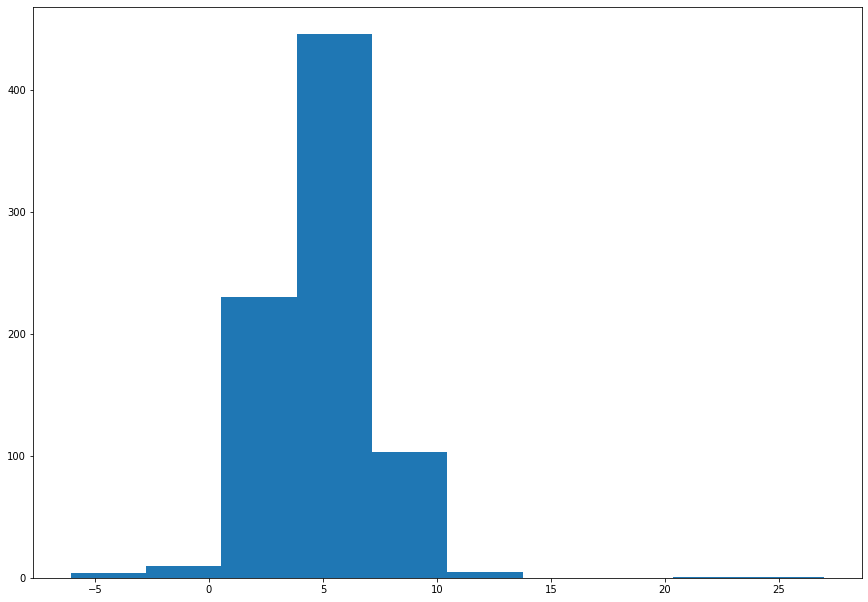

In [400]:
plt.figure(figsize=(29.7/2, 21.0/2))
plt.hist(y_train)
plt.show()

* Попытаемся найти оптимальную оценку Надарайа-Ватсона

In [403]:
gs = RandomizedSearchCV(
    KernelRegression(),
    param_distributions={'gamma': sps.uniform(loc=0.1, scale=2)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    random_state=13,
    n_iter=500
).fit(X_train, y_train)

kr = gs.best_estimator_
print("Best score is ", gs.best_score_)
kr

Best score is  -3.4595683241552764


KernelRegression(gamma=0.8843813258258434, kernel='rbf')

* Найдём оптимальную линейную регрессию

In [412]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
gs = RandomizedSearchCV(
    Ridge(),
    param_distributions={'alpha': sps.uniform(loc=0.01, scale=20)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    n_iter=300
).fit(X_train_scaled, y_train)

lr = gs.best_estimator_
print("Best score is ", gs.best_score_)
lr

Best score is  -3.8039058641075227


Ridge(alpha=14.37859747422873, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

* Найдём оптимальную модель алгоритма настройки с возвращением

In [416]:
%%time
gs = RandomizedSearchCV(
    ConfigureReturn(niter=3),
    param_distributions={'gamma': sps.uniform(loc=0.1, scale=20)},
    cv=KFold(20),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    n_iter=20
).fit(X_train.values, y_train.values)

cr = gs.best_estimator_
print("Best score is ", gs.best_score_)
cr

Best score is  -3.2666867797474035
CPU times: user 7.39 s, sys: 173 ms, total: 7.56 s
Wall time: 6min 14s


ConfigureReturn(gamma=9.636989491127961, niter=3)

* **Вывод:**

Так как б`ольшая часть работы уже проделана в 4-ом задании. То здесь я так же поэксперементировал с тремя моделями
Настройка с возвращением так же показала лучший результат. Для предсказания на X_train я использовал бы этот метод